In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 


Load Dataset

In [12]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "AirPassengers.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "rakannimer/air-passengers",
    file_path,
)

/var/folders/35/h2vzj0092n76sg7z3vjwcv3r0000gn/T/ipykernel_47551/3531548581.py:6: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


Checking what all is present in the dataset

In [13]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [14]:
df.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [18]:
df.columns

Index(['Month', '#Passengers'], dtype='object')

Renaming the Columns for better access

In [19]:
df.columns=["Month", "Pass"]

Convert the month into datetime variables as it is a time series dataset

In [22]:
df['Month'] = pd.to_datetime(df['Month'])

Setting Month column as the margin

In [24]:
df.set_index('Month', inplace=True)

Final Converted Data

In [25]:
df.head()

,Pass
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [26]:
df.describe()

,Pass
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Plotting how the data looks like

<Axes: xlabel='Month'>

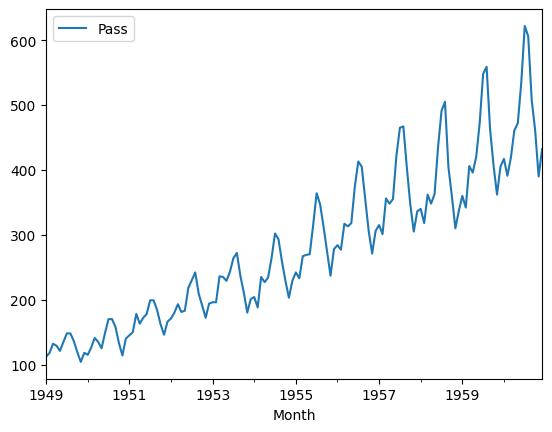

In [27]:
df.plot()

To check if the Data is Stationary using Dickey-Fuller Test

In [30]:
from statsmodels.tsa.stattools import adfuller
test_res = adfuller(df['Pass'])

In [36]:
def adfuller_test(passe) : 
    result = adfuller(passe)
    labels = ['ADF Test Statistic', 'p-Value', 'Lags Used', 'Number of Obs. Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho). Reject the Null Hypothesis.\nData has no unit root & is not Stationary.")
    else:
        print("Weak evidence against the null hypothesis, Time series has a unit root.Data is non-stationary. ")

adfuller_test(df['Pass'])

ADF Test Statistic : 0.815368879206053
p-Value : 0.9918802434376411
Lags Used : 13
Number of Obs. Used : 130
Weak evidence against the null hypothesis, Time series has a unit root.Data is non-stationary. 


Since data is non-stationary, we will convert it to Stationary using Differencing(Shfiting a position of the Sales data)

In [45]:
df['Pass First Diff'] = df['Pass'] - df['Pass'].shift(1)

In [46]:
df['Seasonal First Diff'] = df['Pass'] - df['Pass'].shift(12)

In [47]:
df.head(20)

,Pass,Pass First Diff,Pass Second Diff,Seasonal First Diff
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,NaN,NaN
1949-04-01,129,-3.0,NaN,NaN
1949-05-01,121,-8.0,NaN,NaN
1949-06-01,135,14.0,NaN,NaN
1949-07-01,148,13.0,NaN,NaN
1949-08-01,148,0.0,NaN,NaN
1949-09-01,136,-12.0,NaN,NaN


Testing the Data with DF Test to ensure if it is stationary

In [49]:
adfuller_test(df['Seasonal First Diff'].dropna())

ADF Test Statistic : -3.38302072649248
p-Value : 0.01155149308551501
Lags Used : 1
Number of Obs. Used : 130
Strong evidence against the null hypothesis(Ho). Reject the Null Hypothesis.
Data has no unit root & is not Stationary.


<Axes: xlabel='Month'>

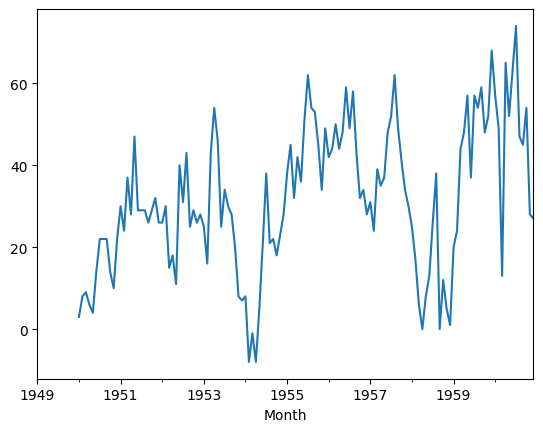

In [50]:
df['Seasonal First Diff'].plot()

Implementing an AutoRegressive Model

Checking the ACF for the Dataset

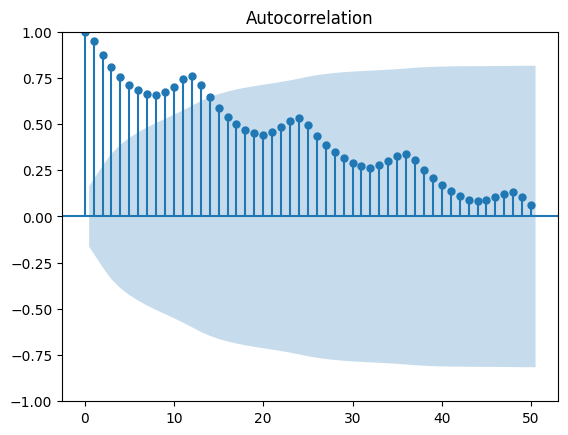

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import matplotlib.pyplot as plt
plot_acf(df["Pass"], lags=50)  
plt.show()

Plotting ACF and PACF for Seasonal Differences

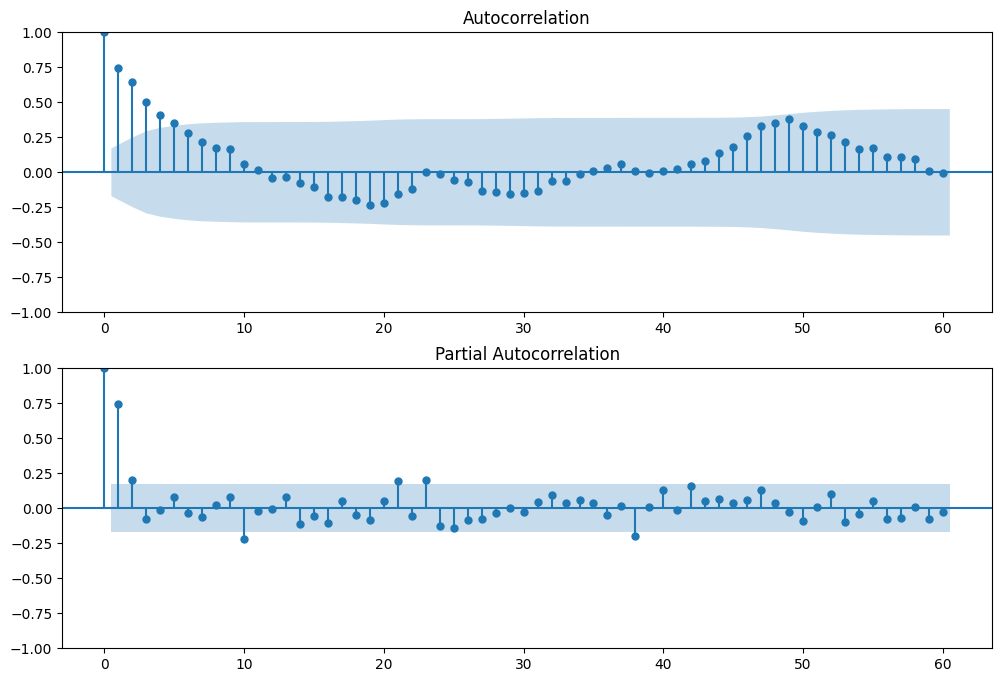

In [61]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(df['Seasonal First Diff'].dropna(), lags=60, ax=ax1)

ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(df['Seasonal First Diff'].dropna(), lags=60, ax=ax2)
plt.show()

1. PACF Cuts off after Lag 1 : p=1
2. Seasonal Differencing with d=1 as it changes at about 12 then 24, 36
3. ACF shows a slow decay so q=1 indicating prime AR
4. Thus Consider a AR(1) MODEL

#Since there is seasonality, we should preferably implement SARIMA. But usin ARIMA to test out the differences

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# Fit ARIMA(p,d,q)
ar = ARIMA(df['Pass'], order=(1,1,1))
ar_fit = ar.fit()

print(ar_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Pass   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Sun, 31 Aug 2025   AIC                           1394.683
Time:                        13:58:12   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.0

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


	•	ar.L1 (the AR(1) coefficient): -0.47 means the series depends negatively on its last lag. If the last value was higher, the model expects the next differenced value to be lower, and vice versa.
	•	ma.L1 (the MA(1) coefficient): 0.86 means the model strongly uses the last error term to improve predictions.
	•	sigma²: estimated variance of the error/residuals.

All p-values (P>|z|) are 0.000, meaning these coefficients are statistically significant.

	•	Ljung-Box: tests autocorrelation in residuals.
	•	p=0.65 → residuals look uncorrelated (good).
	•	Jarque-Bera: tests normality of residuals.
	•	p=0.34 → residuals are reasonably normal (good).
	•	Heteroskedasticity: tests if residual variance changes over time.
	•	p=0.00 → heteroskedasticity is present (variance not constant). This is common in real-world data.

	•	The ARIMA(1,1,1) is a reasonable fit.
	•	Both AR and MA terms are significant.
	•	Residuals are uncorrelated and roughly normal - good signs.
	•	But there is heteroskedasticity - I could consider GARCH-type models if volatility modeling is important.

Model Fitting Visualisation for ARIMA

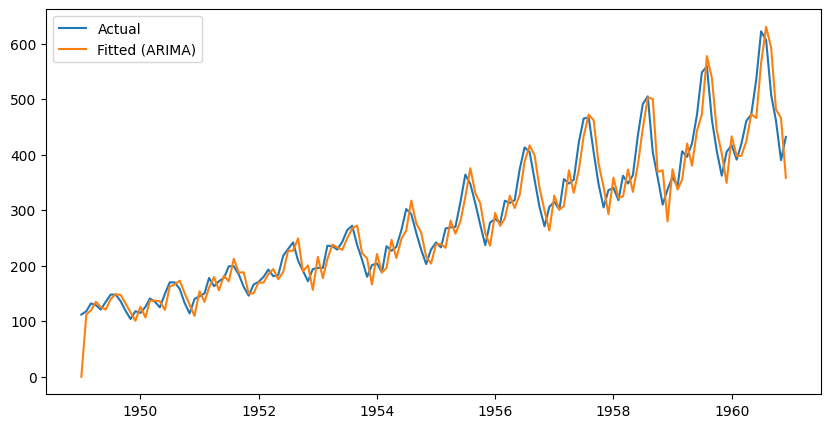

In [ ]:
df["forecast"] = ar_fit.fittedvalues

plt.figure(figsize=(10,5))
plt.plot(df["Pass"], label="Actual")
plt.plot(df["forecast"], label="Fitted (ARIMA)")
plt.legend()
plt.show()

Prediction for next 10 years using ARIMA

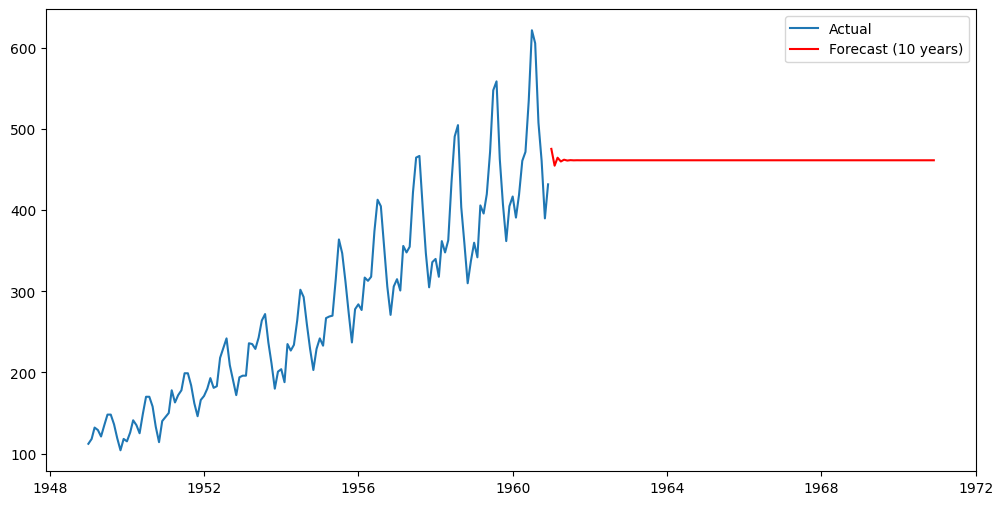

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

forecast_steps = 120
forecast = ar_fit.forecast(steps=forecast_steps)
future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), 
                             periods=forecast_steps, freq="MS")

# Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Pass"], label="Actual")
plt.plot(future_dates, forecast, label="Forecast (10 years)", color="red")
plt.legend()
plt.show()

In [72]:
import statsmodels.api as sm
sar = sm.tsa.statespace.SARIMAX(df['Pass'], order=(1,1,1), seasonal_order=(1,1,1,12))
sar_fit = sar.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Pass   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.149
Date:                            Sun, 31 Aug 2025   AIC                           1022.299
Time:                                    14:09:08   BIC                           1036.675
Sample:                                01-01-1949   HQIC                          1028.140
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1272      0.356     -0.358      0.721      -0.825       0.570
ma.L1         -0.2148      0.325   

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


	•	The seasonal terms (lag 12 AR & MA) are very strong and highly significant, which makes sense because the airline passenger data has a clear annual seasonal cycle.
	•	The non-seasonal AR and MA terms are weak (p > 0.5), so they don’t contribute much.

Log Likelihood = -506.149
AIC = 1022.299
BIC = 1036.675
HQIC = 1028.140

	•	AIC (Akaike Information Criterion) → Lower = better. Used to compare models.
	•	BIC (Bayesian Information Criterion) → Similar, but penalizes complexity more heavily.


Ljung-Box (L1) (Q) = 0.00, Prob(Q) = 0.99

	•	Tests whether residuals are white noise (uncorrelated).
	•	Since p=0.99 > 0.05,  residuals are uncorrelated → model captures autocorrelation well.

Jarque-Bera (JB) = 7.05, Prob(JB) = 0.03

	•	Tests whether residuals are normally distributed.
	•	p=0.03 < 0.05 → residuals deviate somewhat from normality (slight skew/kurtosis).

Heteroskedasticity (H) = 2.65, Prob(H) = 0.00

	•	Tests variance constancy.
	•	p=0.00 → evidence of heteroskedasticity (variance not constant, perhaps increasing with time).

Model Fitting Visualsisation for SARIMAX

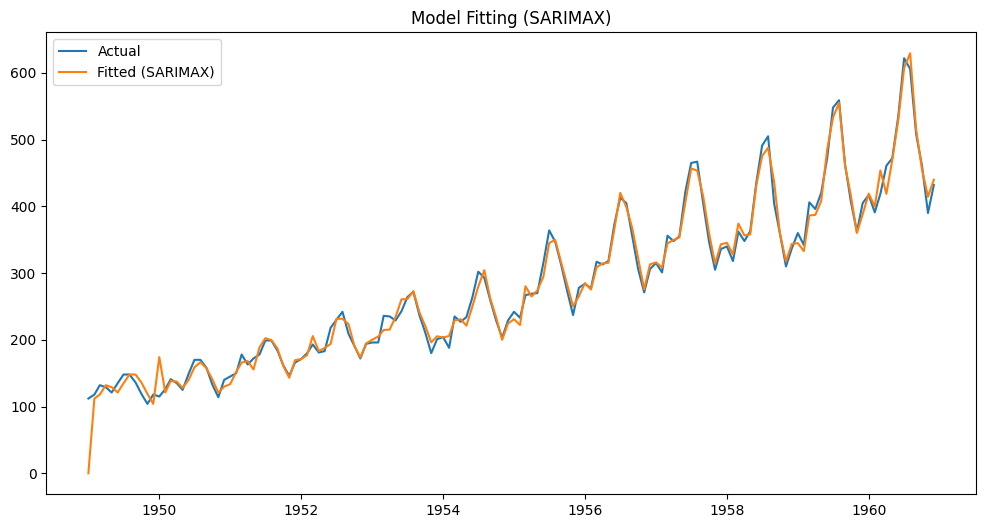

In [73]:
df["fitted"] = sar_fit.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(df["Pass"], label="Actual")
plt.plot(df["fitted"], label="Fitted (SARIMAX)")
plt.title("Model Fitting (SARIMAX)")
plt.legend()
plt.show()

Plotting the Predictions for the next 10 years : 

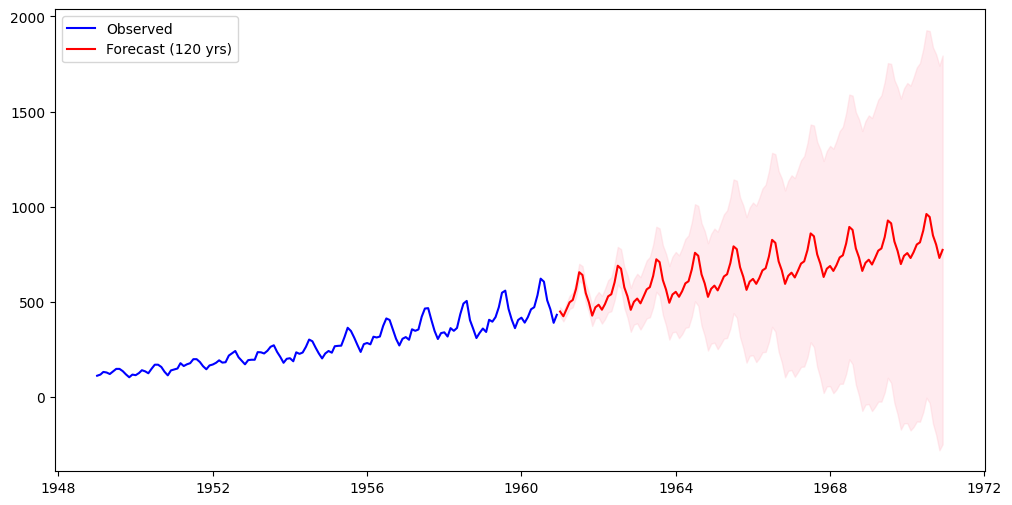

In [ ]:
ts = df["Pass"]

pred_mean = forecast.predicted_mean
C = forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(ts, label="Observed", color="blue")
plt.plot(pred_mean.index, pred_mean, label="Forecast (120 yrs)", color="red")
plt.fill_between(conf_int.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color='pink', alpha=0.3)
plt.legend()
plt.show()

Seeing the Raw values : 

In [82]:
print(pred_mean)

1961-01-01    449.330183
1961-02-01    424.386405
1961-03-01    459.033327
1961-04-01    497.865408
1961-05-01    509.863418
                 ...    
1970-08-01    945.986628
1970-09-01    848.867954
1970-10-01    801.154628
1970-11-01    730.670302
1970-12-01    773.100157
Freq: MS, Name: predicted_mean, Length: 120, dtype: float64
